In [18]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

from scipy.stats import multivariate_normal 
from scipy.stats import invwishart 

from sklearn import metrics
from scipy.special import psi


In [19]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Dataset

# 2 Algorithm

#### Assume Sigma is known, and estimate $\pi$ by MLE


We want to compute the intractable GMM posterior:
$$
    p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\mathbf{X},\boldsymbol{\Sigma}) = \frac{p(\mathbf{X},\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}|\boldsymbol{\Sigma})}{p(\mathbf{X}|\boldsymbol{\Sigma})}
$$

Introduce approximating distribution $q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})$ where we use KL divergence as a cost function 
$$
    \mathbb{KL}(q||p) = \sum_{\mathbf{z},\boldsymbol{\mu}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log\frac{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\mathbf{X},\boldsymbol{\Sigma})}
$$

Re-write as objective function
$$\begin{align}
    \mathcal{J}(q) &= \mathbb{KL}(q||p) = \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log\frac{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\mathbf{X},\boldsymbol{\Sigma})}d\boldsymbol{\mu}d\boldsymbol{\pi}\\

        &=  \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})d\boldsymbol{\mu}d\boldsymbol{\pi} - \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\mathbf{X},\boldsymbol{\Sigma})d\boldsymbol{\mu}d\boldsymbol{\pi}\\

        &= \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})d\boldsymbol{\mu}d\boldsymbol{\pi} - 
            \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log \frac{p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})}{p(\mathbf{X}|\boldsymbol{\Sigma})}d\boldsymbol{\mu}d\boldsymbol{\pi}\\

        &= \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})d\boldsymbol{\mu}d\boldsymbol{\pi} - \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})d\boldsymbol{\mu} + \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log p(\mathbf{X}|\boldsymbol{\Sigma})d\boldsymbol{\mu}d\boldsymbol{\pi}\\

        &= \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})d\boldsymbol{\mu}d\boldsymbol{\pi} - \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})d\boldsymbol{\mu} + \log p(\mathbf{X}|\boldsymbol{\Sigma})d\boldsymbol{\pi}\\

        &= \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log \frac{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})}d\boldsymbol{\mu}d\boldsymbol{\pi} + \log p(\mathbf{X}|\boldsymbol{\Sigma})\\

        &= \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big) + \log p(\mathbf{X}|\boldsymbol{\Sigma})
\end{align}$$

Note 
$$
    \mathcal{J}(q) = \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big) + \underbrace{\log p(\mathbf{X}|\boldsymbol{\Sigma})}_{\text{constant}}
$$

Hence our objective can simplify to
$$\begin{align}
    q* &\leftarrow \argmin_{q} \left[  \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big)  + \underbrace{\log p(\mathbf{X}|\boldsymbol{\Sigma})}_{\text{constant}} \right]\\
        &= \argmin_{q} \left[ \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big) \right]
\end{align}$$

Define new objective function as $\mathcal{L}(q) = -\mathcal{J}(q) = -\mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big) - \log p(\mathbf{X}|\boldsymbol{\Sigma})$

We can show that $\mathcal{L}(q)$ is ELBO for data log likelihood :
$$\begin{align}
    \log p(\mathbf{X}|\boldsymbol{\Sigma}) = \log \int\int \sum_z p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})d\mu d\boldsymbol{\pi}
\end{align}$$
The following always holds
$$\begin{align}
    \log p(\mathbf{X}) = \log \int \int \sum_z q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}) \cdot \frac{p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})}{q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi})} d\mu d\boldsymbol{\pi} 
\end{align}$$    
Jensen's Inequality gives the following
$$\begin{align}
    &\log p(\mathbf{X}|\boldsymbol{\Sigma}) = \log \int \int \sum_z q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}) \cdot \frac{p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})}{q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi})} d\mu d\boldsymbol{\pi} \geq \int \int \sum_z q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}) \cdot \log \frac{p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})}{q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi})} d\mu d\boldsymbol{\pi} \\\\

    &\implies \log p(\mathbf{X}|\boldsymbol{\Sigma}) \geq \int \int \sum_z q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}) \cdot \log \frac{p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})}{q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi})} d\mu d\boldsymbol{\pi}\\\\

    &\implies \log p(\mathbf{X}|\boldsymbol{\Sigma}) \geq -\mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big)\\\\

    &\implies \log p(\mathbf{X}|\boldsymbol{\Sigma}) \geq \mathcal{L}(q)
\end{align}$$
Therefore by maximizing $\mathcal{L}$, we bring $q$ closer to true posterior and maximize ELBO of marginal data log likelihood.

---

We have 
$$
    \mathcal{L}(q) = \mathbb{E}_{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})}[\log p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})] - \mathbb{E}_{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})}[\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})]
$$

And want to compute 
$$
    \frac{d\mathcal{L}}{q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi})} = 0
$$

---

## Mean Field
Mean Field Independence Simplifying Assumption :
$$
    q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}) = q(\boldsymbol{\pi})\underbrace{q(\mathbf{z})}_{\text{Cat}} \underbrace{q(\boldsymbol{\mu})}_{\text{Gaussian}}
$$

### Mean Field Update Steps 
$$\begin{align}
    \log q(\boldsymbol{\mu},\boldsymbol{\pi}) &= \mathbb{E}_{q(\mathbf{z})}[\log p(\mathbf{z},\boldsymbol{\mu},\mathbf{X}|\boldsymbol{\Sigma})] + \text{const}\\
    \log q(\mathbf{z}) &= \mathbb{E}_{q(\boldsymbol{\mu},\boldsymbol{\pi})}[\log p(\mathbf{z},\boldsymbol{\mu},\mathbf{X}|\boldsymbol{\Sigma})] + \text{const}\\
\end{align}$$

Assumptions 
1) Prior on $\boldsymbol{\pi}$ is Dirichlet
2) Prior on $\boldsymbol{\mu}$ is MVN
3) Prior on $\mathbf{z}$ is categorical
4) Sigma is known

The posterior
$$
    p(\mathbf{X},\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}|\boldsymbol{\Sigma}) \propto p(\mathbf{X}|\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{z})p(\boldsymbol{\mu})p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi})
$$


### Updates for variational posterior of model parameters $q(\boldsymbol{\pi},\boldsymbol{\mu})$


$$\begin{align}
    \log q(\boldsymbol{\pi},\boldsymbol{\mu}) &= \mathbb{E}_{q(\mathbf{z})}\Big[\log p(\mathbf{X},\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}|\boldsymbol{\Sigma})\Big] + \text{const}\\

    &= \mathbb{E}_{q(\mathbf{z})}\Big[\log p(\mathbf{X}|\boldsymbol{\mu},\mathbf{z},\boldsymbol{\Sigma})p(\boldsymbol{\mu})p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi})\Big] + \text{const}\\

    &= \mathbb{E}_{q(\mathbf{z})}\Big[ \log {p(\boldsymbol{\pi})} + \log p(\mathbf{z}|\boldsymbol{\pi}) +p(\mathbf{X}|\boldsymbol{\mu},\mathbf{z},\boldsymbol{\Sigma}) \Big] + \log p(\boldsymbol{\mu}) + \text{const}\\ 

    &= \log p(\boldsymbol{\pi}) + \mathbb{E}_{q(\mathbf{z})}\Big[ \log p(\mathbf{z}|\boldsymbol{\pi}) \Big] + \mathbb{E}_{q(z)}\Big[ \log p(\mathbf{X}|\boldsymbol{\mu},
    \mathbf{z},\boldsymbol{\Sigma}) \Big] + \log p(\boldsymbol{\mu}) + \text{const}\\
\end{align}$$

Can separate RHS into terms containing $\pi$ and $\mu$ for update steps $q(\pi)$ and $q(\mu)$  

Update Step for $q(\boldsymbol{\pi})$  

$$\begin{align}
    \log q(\boldsymbol{\pi}) &= \log p(\boldsymbol{\pi}) + \mathbb{E}_{q(\mathbf{z})}\Big[ \log p(\mathbf{z}|\boldsymbol{\pi}) \Big] + \text{const}\\

    &= \log \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0) + \mathbb{E}_{q(\mathbf{z})}\Big[ \sum_n^N \log p(z_n|\boldsymbol{\pi}) \Big] + \text{const}\\

    &= \log \Big[ \frac{1}{B(\alpha_0)}\prod_k^K \pi_k^{\alpha_0 - 1} \Big] + \mathbb{E}_{q(z)} \Big[\sum_n^N \log p(z_n|\boldsymbol{\pi}) \Big] + \text{const}\\

    &=  \underbrace{-\log B(\alpha_0)}_{\text{Independent of $\pi$}} + \sum_k^K \log \pi_k^{\alpha_0 - 1} + \mathbb{E}_{q(\mathbf{z})} \Big[ \sum_n^N \log \prod_k^K \pi_{k}^{z_{nk}} \Big] + \text{const}, \quad \text{where z$_{nk}$ is zero-hot}\\ 

    &=   \sum_k^K (\alpha_0 - 1) \log \pi_k + \mathbb{E}_{q(\mathbf{z})}\Big[ \sum_n^N \sum_k^K  z_{nk}\log \pi_{k} \Big] + \text{const}, \quad -\log B(\alpha_0) \text{ absorbed into const}\\

    &=   \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N  \mathbb{E}_{q(\mathbf{z})}\big[z_{nk}\big] \log \pi_{k} + \text{const}\\

    &=   \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N r_{nk} \cdot \log \pi_{k} + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 - 1) \log \pi_k + \sum_n^N r_{nk} \cdot \log \pi_{k} \Big] + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 - 1) \log \pi_k + \log \pi_{k} \sum_n^N r_{nk} \Big] + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 + N_k -1) \log \pi_k  \Big] + \text{const}, \quad \text{where } N_k = \sum_n^N r_{nk} \\

    \implies & \boxed{q(\boldsymbol{\pi}) = \prod_k^K \pi_k^{\alpha_0 + N_k - 1} + \text{const} = \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0 + N), \quad \text{where } N = [N_0,...,N_K]}\\

\end{align}$$



Update step for $q(\boldsymbol{\mu})$  

$$\begin{align}
    \log q(\boldsymbol{\mu}) &= \mathbb{E}_{q(\mathbf{z})}\Big[ \log p(\mathbf{X}|\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{z}) \Big] +  \log p(\boldsymbol{\mu}) +\text{const}\\

    &= \mathbb{E}_{q(\mathbf{z})}\Big[\sum_n^N \log \prod_k^K p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)^{z_{nk}} \Big] +  \log p(\boldsymbol{\mu}) +\text{const}\\

    &= \mathbb{E}_{q(\mathbf{z})}\Big[\sum_n^N \sum_k^K \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)^{z_{nk}} \Big] +  \log p(\boldsymbol{\mu}) +\text{const}\\

    &= \sum_n^N \sum_k^K \mathbb{E}_{q(\mathbf{z})}\big[z_{nk}\big] \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) +  \log p(\boldsymbol{\mu}) +\text{const}\\

    &= \sum_k^K \sum_n^N  \Big[ r_{nk} \cdot \log p(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \sum_k^K \log p(\mu_k) + \text{const}\\

    &= \sum_k^K \Big[ \log p(\mu_k) +  \sum_n^N r_{nk} \log p(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \text{const} \\

    \implies & \log q(\boldsymbol{\mu}) = \sum_k^K \log q(\mu_k)\\
\end{align}$$
Hence,
$$\begin{align}
    \log q(\boldsymbol{\mu}_k) &= \log p(\boldsymbol{\mu}_k) +  \sum_n^N r_{nk} \log p(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) + \text{const}\\

    &= \log \mathcal{N}(\boldsymbol{\mu}_k|\mathbf{m}_{0,k}, \mathbf{V}_{0,k}) + \sum_n^N r_{nk} \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) + \text{const}\\

    &= \big( \underbrace{-\frac{1}{2}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T\mathbf{V}_{0,k}^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k})}_{\text{Terms dependent on $\mu_k$}} \big) + \sum_n^N r_{nk} \big(\underbrace{-\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k)}_{\text{Terms dependent on $\mu_k$}}\big) + \text{const}\\

    &=  -\frac{1}{2}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T\mathbf{V}_{0,k}^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) - \frac{1}{2}\Big[\underbrace{\text{Tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{\bar{\mathbf{x}}_k})}_{\text{Constant w.r.t $\boldsymbol{\mu}_k$}} + N_k(\bar{\mathbf{x}}_k - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\bar{\mathbf{x}}_k - \boldsymbol{\mu}_k)\Big] + \text{const}, \quad \text{where } N_k = \sum_n^N r_{nk},\quad \bar{\mathbf{x}}_k = \sum_n^N r_{nk}\cdot\mathbf{x}_n\\

    &= -\frac{1}{2}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T\mathbf{V}_{0,k}^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) - \frac{N_k}{2}(\bar{\mathbf{x}}_k - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\bar{\mathbf{x}}_k - \boldsymbol{\mu}_k) + \text{const}, 
    \quad \text{Trace absorbed into const}\\\\

    &= -\frac{1}{2}\Big[
        \underbrace{ \boldsymbol{\mu}_k^T\mathbf{V}_{0,k}^{-1}\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\mathbf{V}_k^{-1}\mathbf{m}_{0,k} + \mathbf{m}_{0,k}^T\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k}}_{\text{Prior Component}} + 
        
        \underbrace{N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k - 2N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k + N_k\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k}_{\text{Likelihood Component}} \Big] + \text{const}\\\\

    &= -\frac{1}{2} \Big[ 
        \big(\boldsymbol{\mu}_k^T\mathbf{V}_{0,k}^{-1}\boldsymbol{\mu}_k  + N_k\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k) -
        \big(2\boldsymbol{\mu}_k^T\mathbf{V}_k^{-1}\mathbf{m}_{0,k} - 2N_k\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k) + 
        \big(\mathbf{m}_{0,k}^T\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k)
    \Big] + \text{const}, \quad \text{Re-group terms}\\\\

    &= -\frac{1}{2} \Big[ 
            \boldsymbol{\mu}_k^T(\mathbf{V}_k^{-1} - N_k\boldsymbol{\Sigma}_k^{-1})\boldsymbol{\mu}_k \quad - \quad 
            
            2\boldsymbol{\mu}_k^T(\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + N_k\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}_n^T}) \quad + \quad 
            
            \mathbf{m}_{0,k}^T\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k 
        \Big] + \text{const}\\\\

    &= -\frac{1}{2} \Big[
        \big(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b} \big)^T \mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b}) - \underbrace{\mathbf{b^TM^{-1}b}}_{\text{Independent of $\boldsymbol{\mu}_k$}}
    \Big] + \text{const}, \quad \text{Complete the multivariate square}\\

    &\text{where},\\
        &\qquad\qquad \mathbf{M} = (\mathbf{V}_k^{-1} - N_k\boldsymbol{\Sigma}_k^{-1})\\
        &\qquad\qquad \mathbf{b} = (\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + N_k\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}_n^T})\\\\
    

    &= -\frac{1}{2} \Big[
        \big(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b} \big)^T \mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})
    \Big] + \text{const}, \quad \text{Absorb independent terms into constant}\\\\
    

    &\implies q(\mu_k) = \exp \Big( -\frac{1}{2} \big[
        \big(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b} \big)^T \mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})
    \big] \Big) + \text{const}\\

\end{align}$$

This is MVN form. Hence,

$$\begin{align}
    q(\mu_k) &=  \mathcal{N}\Big(\mu_k|\mathbf{m}_k,\mathbf{V}_k \Big)\\
        & N_k = \sum_n^N \gamma_{n,k}\\
        & \bar{\mathbf{x}}_k = \frac{1}{N_k}\sum_n^N \gamma_{n,k} \cdot \mathbf{x}_n\\
        & \mathbf{V}_k = \Big(\mathbf{V}_{0,k}^{-1} + N_k\Sigma_k^{-1}\Big)^{-1}\\
        & \mathbf{m}_k = \mathbf{V}_k \Big(\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + \Sigma_k^{-1}(N_k\bar{\mathbf{x}}_k) \Big)
\end{align}$$

### Updates for variational posterior of latent variable $q(\mathbf{z})$

$$\begin{align}
    \log q(\mathbf{z}) &= \mathbb{E}_{q(\boldsymbol{\mu},\boldsymbol{\pi})} \Big[ \log p(\mathbf{X},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{z}|\boldsymbol{\Sigma}) \Big] + \text{const}\\

    &= \mathbb{E}_{q(\boldsymbol{\mu},\boldsymbol{\pi})} \Big[ \log p(\mathbf{X}|\boldsymbol{\mu},\mathbf{z},\boldsymbol{\Sigma}) p(\boldsymbol{\mu}) p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi}) \Big] + \text{const}\\

    &= \mathbb{E}_{q(\boldsymbol{\mu},\boldsymbol{\pi})} \Big[ \log p(\mathbf{X}|\boldsymbol{\mu},\mathbf{z},\boldsymbol{\Sigma})\Big] + \mathbb{E}_{q(\boldsymbol{\pi})} \Big[ \log p(\mathbf{z}|\boldsymbol{\pi}) \Big] + \underbrace{\mathbb{E}_{q(\boldsymbol{\mu})} \Big[ \log p(\boldsymbol{\mu}) \Big] + \mathbb{E}_{q(\boldsymbol{\pi})} \Big[ \log p(\boldsymbol{\pi}) \Big]}_{\text{Independent of $\mathbf{z}$}} + \text{const}\\

    &=  \mathbb{E}_{q(\boldsymbol{\mu},\boldsymbol{\pi})} \Big[ \log p(\mathbf{X}|\boldsymbol{\mu},\mathbf{z},\boldsymbol{\Sigma}) \Big] + \mathbb{E}_{q(\boldsymbol{\pi})} \Big[ \log p(\mathbf{z}|\boldsymbol{\pi}) \Big] + \text{const}, \quad \text{Independent terms absorbed into const}\\\\


    &= \mathbb{E}_{q(\boldsymbol{\mu})} \Big[ \sum_n^N \sum_k^K \log p(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k)^{z_{nk}} \Big] + \mathbb{E}_{q(\boldsymbol{\pi})} \Big[ \sum_n^N \sum_k^K \log p(z_n=k|\boldsymbol{\pi})^{z_{nk}} \Big] + \text{const}\\

    &= \sum_n^N \sum_k^K \mathbb{E}_{q(\boldsymbol{\mu})} \Big[z_{nk} \cdot \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \sum_n^N \sum_k^K \mathbb{E}_{q(\boldsymbol{\pi})} \Big[ z_{nk} \cdot \log \boldsymbol{\pi}_{k} \Big] + \text{const}\\

    &= \sum_n^N \left[ \sum_k^K \mathbb{E}_{q(\boldsymbol{\mu})} \Big[z_{nk} \cdot \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \sum_k^K \mathbb{E}_{q(\boldsymbol{\pi})} \Big[ z_{nk} \cdot \log \boldsymbol{\pi}_{k} \Big]\right] + \text{const}\\

    \implies & \log q(\mathbf{z}) = \prod_n^N q(z_n)
\end{align}$$
Hence
$$\begin{align}
    \log q(z_n) &= \sum_k^K \mathbb{E}_{q(\boldsymbol{\mu})} \Big[z_{nk} \cdot \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \sum_k^K \mathbb{E}_{q(\boldsymbol{\pi})} \Big[ z_{nk} \cdot \log \boldsymbol{\pi}_{k} \Big] + \text{const}\\

    &= \sum_k^K \Big[ \mathbb{E}_{q(\boldsymbol{\mu})} \big[z_{nk} \cdot \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \big] + \mathbb{E}_{q(\boldsymbol{\pi})} \big[ z_{nk} \cdot \log \boldsymbol{\pi}_{k} \big] \Big] + \text{const} \\

    &= \sum_k^K  z_{nk} \cdot \Big[ \mathbb{E}_{q(\boldsymbol{\mu})}\big[ \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \big] + \mathbb{E}_{q(\boldsymbol{\pi})}\big[ \log \boldsymbol{\pi}_{k} \big]  \Big] + \text{const}\\
\end{align}$$

This gives 

$$\begin{align}
    \log q(z_n=k) &= \underbrace{\mathbb{E}_{q(\boldsymbol{\mu})}\Big[ \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big]}_{(1)} + \underbrace{\mathbb{E}_{q(\boldsymbol{\pi})}\Big[ \log \boldsymbol{\pi}_{k} \Big]}_{(2)} + \text{const}
\end{align}$$
where
$$\begin{align}
     (1) \quad \mathbb{E}_{q(\boldsymbol{\mu})}\Big[ \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] &= \mathbb{E}_{q(\boldsymbol{\mu})}\Big[ \underbrace{-\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k)}_{\text{Terms dependent on $\boldsymbol{\mu}_k$}} \Big],\quad \text{Independent terms absorbed to const}\\\\

    &= -\frac{1}{2}\Bigg[\mathbb{E}_{q(\boldsymbol{\mu})} \Big[\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k \Big]\Bigg]\\\\

    &= -\frac{1}{2}\Bigg[ 
            \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 
            2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1} \mathbb{E}_{q(\boldsymbol{\mu})}\Big[\boldsymbol{\mu}_k\Big] + 
            \mathbb{E}_{q(\boldsymbol{\mu})}\Big[\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k\Big]
        \Bigg]\\\\

    &= -\frac{1}{2}\Bigg[ 
            \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 
            2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1} \mathbb{E}_{q(\boldsymbol{\mu})}\Big[\boldsymbol{\mu}_k\Big] + 
            \mathbb{E}_{q(\boldsymbol{\mu})}\Big[\text{tr}(\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k)\Big]
        \Bigg]\\\\

    &= -\frac{1}{2}\Bigg[
            \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 
            2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1} \mathbb{E}_{q(\boldsymbol{\mu})}\Big[\boldsymbol{\mu}_k\Big] + 
            \mathbb{E}_{q(\boldsymbol{\mu})}\Big[\text{tr}(\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k\boldsymbol{\mu}_k^T)\Big]
        \Bigg], \quad \text{Trace cyclic property}\\\\

    &= -\frac{1}{2}\Bigg[
            \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 
            2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1} \mathbb{E}_{q(\boldsymbol{\mu})}\Big[\boldsymbol{\mu}_k\Big] + 
            \text{tr}\Big(\mathbb{E}_{q(\boldsymbol{\mu})}\big[\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k\boldsymbol{\mu}_k^T\big]\Big)
        \Bigg]\\\\

    &= -\frac{1}{2}\Bigg[
            \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 
            2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1} \mathbb{E}_{q(\boldsymbol{\mu})}\Big[\boldsymbol{\mu}_k\Big] + 
            \text{tr}\Big(\underline{\boldsymbol{\Sigma}_k^{-1} \cdot \mathbb{E}_{q(\boldsymbol{\mu})}\big[\boldsymbol{\mu}_k\boldsymbol{\mu}_k^T\big]}\Big)
        \Bigg], \quad \boldsymbol{\Sigma}_k^{-1} \text{ constant to expectation}\\\\

    &= -\frac{1}{2}\Bigg[
            \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 
            2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1} \underline{\mathbf{m}_{k} }+ 
            \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1} \cdot (\underline{\mathbf{m}_{k}\mathbf{m}_{k}^T + \mathbf{V}_{k}} )\Big)
        \Bigg]
        ,\quad \text{ For } q(\boldsymbol{\mu}_k ) = \mathcal{N}(\mathbf{m}_{k},\mathbf{V}_{k})\\\\

    &= -\frac{1}{2}\Bigg[
            \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 
            2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1} \mathbf{m}_{k} + 
            \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{k}\mathbf{m}_{k}^T + \boldsymbol{\Sigma}_k^{-1}\mathbf{V}_{k} \Big)
        \Bigg]\\\\

    &= -\frac{1}{2}\Bigg[
            \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 
            2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1} \mathbf{m}_{k} + 
            \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{k}\mathbf{m}_{k}^T\Big) + \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}\mathbf{V}_{k} \Big)
        \Bigg]\\\\

    &= -\frac{1}{2}\Bigg[
            \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 
            2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1} \mathbf{m}_{k} + 
            \text{tr}\Big(\mathbf{m}_{k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{k}\Big) + \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}\mathbf{V}_{k} \Big)
        \Bigg]\\\\

    &= -\frac{1}{2}\Bigg[
            \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 
            2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1} \mathbf{m}_{k} + 
            \mathbf{m}_{k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{k} + 
            \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}\mathbf{V}_{k} \Big)
        \Bigg]\\\\

    &= -\frac{1}{2}\Bigg[
            \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}\mathbf{V}_{k} \Big) + 
        (\mathbf{x}_n - \mathbf{m}_{k})^T \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_n - \mathbf{m}_{k})
        \Bigg]\\\\
\end{align}$$

For (2), given that each marginal of a Dirichlet distribution is a Beta distribution with : $\boldsymbol{\pi}_k \sim \text{Beta}(\alpha_k, \sum_{k'}\alpha_{k'}-\alpha_k)$  
And that if $X\sim\text{Beta}(a,b)$, then $\mathbb{E}[\log X] = \psi(a) - \psi(a + b)$
$$\begin{align}
    (2) \quad \mathbb{E}_{q(\boldsymbol{\pi})}\Big[ \log \boldsymbol{\pi}_{k} \Big] = \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big)
\end{align}$$

Hence we get the update step : 
$$\begin{align}
    \log q(z_n=k) &= -\frac{1}{2}\Bigg[ 
                                        \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}\mathbf{V}_{k} \Big) + \
                                        (\mathbf{x}_n - \mathbf{m}_{k})^T \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_n - \mathbf{m}_{k})
                                  \Bigg] +
                     \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) + \text{const}\\\\

    \implies & \boxed{q(z_n=k) =  \exp \Bigg( \psi(\alpha_k) - \psi\big(\sum_{k'}\alpha_{k'}\big) -\frac{1}{2}\Big[ 
                                        \text{tr}\big(\boldsymbol{\Sigma}_k^{-1}\mathbf{V}_{k} \big) + \
                                        (\mathbf{x}_n - \mathbf{m}_{k})^T \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_n - \mathbf{m}_{k})
                                  \Big]  + \underbrace{\text{const}}_{\text{Normalization}}\Bigg)}
\end{align}$$

### In Summary
The update steps for each variable are as follows : 

$$\begin{align}
    &\boxed{q(\boldsymbol{\pi}) = \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0 + N), \quad \text{where } N = [N_0,...,N_K]}\\\\

    &\boxed{q(\mu_k) =  \mathcal{N}\Big(\mu_k|\mathbf{m}_k,\mathbf{V}_k \Big)}\\
        &\qquad\qquad  N_k = \sum_n^N \gamma_{n,k}\\
        &\qquad\qquad \bar{\mathbf{x}}_k = \frac{1}{N_k}\sum_n^N \gamma_{n,k} \cdot \mathbf{x}_n\\
        &\qquad\qquad \mathbf{V}_k = \Big(\mathbf{V}_{0,k}^{-1} + N_k\Sigma_k^{-1}\Big)^{-1}\\
        &\qquad\qquad \mathbf{m}_k = \mathbf{V}_k \Big(\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + \Sigma_k^{-1}(N_k\bar{\mathbf{x}}_k) \Big)\\\\

    &\boxed{q(z_n=k) =  \frac{\exp \Bigg( \psi(\alpha_k) - \psi\big(\sum_{k'}\alpha_{k'}\big) + -\frac{1}{2}\Big[ 
                                        \text{tr}\big(\boldsymbol{\Sigma}_k^{-1}\mathbf{V}_{k} \big) + \
                                        (\mathbf{x}_n - \mathbf{m}_{k})^T \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_n - \mathbf{m}_{k})
                                  \Big]\Bigg)}{\sum_j^K \exp \Bigg( \psi(\alpha_j) - \psi\big(\sum_{k'}\alpha_{k'}\big) + -\frac{1}{2}\Big[ 
                                        \text{tr}\big(\boldsymbol{\Sigma}_j^{-1}\mathbf{V}_{j} \big) + \
                                        (\mathbf{x}_j - \mathbf{m}_{j})^T \boldsymbol{\Sigma}_j^{-1} (\mathbf{x}_j - \mathbf{m}_{j})
                                  \Big]\Bigg)}}
\end{align}$$

In [20]:
def update_μ(X, R, Σ, Λ_0, μ_0, K):
    N, D = X.shape

    S = np.zeros((K, D, D))  # Covariances of q(μ_k)
    m = np.zeros((K, D))     # Means of q(μ_k)

    nk = np.sum(R, axis=0)  # (K,)

    for k in range(K):
        Σ_inv = np.linalg.inv(Σ[k])

        Sk_inv = Λ_0 + nk[k] * Σ_inv
        Sk = np.linalg.inv(Sk_inv)

        mk = Sk @ (Λ_0 @ μ_0 + Σ_inv @ np.sum(R[:, k, None] * X, axis=0))

        S[k] = Sk
        m[k] = mk

    πs = nk / N

    return S, m, πs

In [21]:
def gaussian_data_logprob(X, m, S, Σ, K):
    N,D = X.shape

    logprob= np.zeros((N,K))

    for k in range(K):
        Σ_inv = np.linalg.inv(Σ[k])
        diff = X - m[k][None,:]

        logprob[:,k] = -0.5 * (np.trace(Σ_inv @ S[k]) + np.sum(diff @ Σ_inv * diff, axis=1))
    return logprob

In [22]:
# Add pi_k input parameter for M-Step or E-Step update 
# add loglikelihood function as input 
def update_z(X,dataLogProb,α,K,πs,mode=1):
    ''' 
        @param (X) : input data (n, d)
        @param (m) : mu prior mean (,d)
        @param (S) : mu prior scatter covariance (d,d)
        @param (α) : Dirichlet prior param for π (K,)
        @param (πs) : MLE estimated mixing weights (K,)
        @param (mode) : 0 for Dirichlet prior over π
                        1 for MLE based estimation
                        else for uniform (omit mixing weights)
    '''


    N,D = X.shape 

    R = np.zeros((N,K))

    α_sum = psi(np.sum(α))

    for k in range(K):
        logpi_k = psi(α[k]) - α_sum

        R[:,k] = dataLogProb[:,k].copy()

        if mode == 0:
            R[:,k] += logpi_k
        elif mode == 1:
            R[:,k] += np.log(πs[k])

    log_norm = logsumexp(R, axis=1, keepdims=True)

    R = np.exp(R - log_norm)

    loglik = np.sum(log_norm) / N

    return R,loglik

In [23]:
def update_π(R,K,α_0):
    αs = α_0 + np.sum(R, axis=0)

    return αs

In [24]:
def meanfield_vi(X,K,Σ,mode=1,max_iters=100,tol=1e-5):
    '''
    
    '''

    N,D = X.shape

    μ_0 = X.mean(axis=0)
    Λ_0 = np.cov(X.T) + 1e-3 * np.eye(D)
    α_0 = np.full(K, 1, dtype=np.float64)

    R = rng.dirichlet(alpha=α_0, size=N)  # (N, K)

    loglikes=[]
    
    S = np.zeros((K, D, D))  # Covariances of q(μ_k)
    m = np.zeros((K, D))     # Means of q(μ_k)
    α = np.zeros((K))

    for t in range(max_iters):
        S,m, pis = update_μ(X,R,Σ,Λ_0,μ_0,K)

        dataLogProb = gaussian_data_logprob(X, m, S, Σ, K)

        α = update_π(R,K,α_0)

        R,loglike = update_z(X,dataLogProb,α,K,pis,mode) # 1 for MLE prior

        loglikes.append(loglike)

        if t > 1 and np.abs(loglikes[t] - loglikes[t-1]) < tol:
            break

    return R, S, m, α, loglikes
        


# 2.1 Evaluation

In [25]:
def plot_clusters(X,y,K,m=None,title="GMM Components"):
    colors = plt.cm.tab10(range(K))
    for k,c in zip(range(K),colors):
        indices = (y==k)
        Xi = X[indices]
        plt.scatter(Xi[:, 0], Xi[:, 1], s=12, alpha=0.6, label=f"Component {k}", color=c)

    if m is not None:
        plt.scatter(m[:,0], m[:,1], c='black', s=100, marker='x') 

    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    plt.show()

In [26]:
# component 1
Σ1 = np.array([[2,1.3],[1.3,4]])
μ1 = np.array([1,1])
X1 = np.random.multivariate_normal(μ1, Σ1, size=1000)
y1 = np.zeros((1000))

# component 2
Σ2 = np.array([[2,1.5],[1.5,2]])
μ2 = np.array([-2,6])
X2 = np.random.multivariate_normal(μ2, Σ2, size=900)
y2 = 1 * np.ones((900))

# component 3
Σ3 = np.array([[3,-1.2],[-1.2,1]])
μ3 = np.array([5,-2])
X3 = np.random.multivariate_normal(μ3, Σ3, size=1100)
y3 = 2 * np.ones((1100))

# component 4
Σ4 = np.array([[1,-0.75],[-0.75,2.4]])
μ4 = np.array([6,6])
X4 = np.random.multivariate_normal(μ4, Σ4, size=1000)
y4 = 3 * np.ones((1000))

# component 5
Σ5 = np.array([[3,2.3],[2.3,2.5]])
μ5 = np.array([8,3])
X5 = np.random.multivariate_normal(μ5, Σ5, size=3850)
y5 = 4 * np.ones((3850))

Σ = np.array([Σ1,Σ2,Σ3,Σ4,Σ5])
μ = np.array([μ1,μ2,μ3,μ4,μ5])

X = np.vstack([X1, X2, X3, X4, X5])
y = np.concatenate([y1, y2, y3, y4, y5])

indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

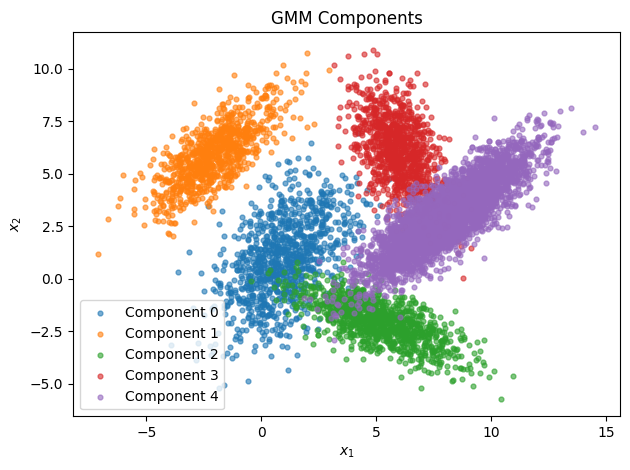

In [27]:
plot_clusters(X,y,5)

Posterior Predictive Distribution
$$\begin{align}
    p(x_{new}|\mathbf{X}) &= \int p(x_{new}|\theta)p(\theta|\mathbf{X})d\theta\\
    
    &= \mathbb{E}_{q(\theta)}\left[\sum_k^K p(x_{new}|\theta_k) \right]\\

    &=  \mathbb{E}_{q(\pi,\mu)}\left[\sum_k^K \pi_k \cdot \mathcal{N}(x_{new}|\mu_k,\Sigma_k) \right]\\

    &=  \sum_k^K \mathbb{E}_{q(\pi_k,\mu_k)}\Big[ \pi_k \cdot \mathcal{N}(x_{new}|\mu_k,\Sigma_k) \Big]\\\\

    &= \sum_k^K \mathbb{E}_{q(\pi_k)}\Big[\pi_k \Big] \cdot \mathbb{E}_{q(\mu_k)}\Big[\mathcal{N}(x_{new}|\mu_k,\Sigma_k)\Big]\\\\

    &= \sum_k^K \Big[\sum_j^K q(\pi_k)\cdot \pi_k\Big]   \cdot \Big[\int q(\mu_k) \cdot \mathcal{N}(x_{new}|\mu_k,\Sigma_k) d\mu_k \Big]\\

    &= \sum_k^K \frac{\alpha_k}{\sum_j^K \alpha_j} \cdot \mathcal{N}(x_{new}|\mathbf{m}_k,\Sigma_k + \mathbf{V}_k) \\

\end{align}$$

In [28]:
def sample_posterior_predictive(N, m, S, Sigma, alpha):

    K, D = m.shape
    pi_exp = alpha / alpha.sum()                
    comps  = rng.choice(K, size=N, p=pi_exp)

    X_new  = np.empty((N, D))
    for idx, k in enumerate(comps):
        cov_pred = Sigma[k] + S[k]           
        X_new[idx] = rng.multivariate_normal(m[k], cov_pred)

    return X_new, comps

Run Algorithm

In [29]:
R, S, m, alphas, loglikes = meanfield_vi(X,5,Σ,max_iters=100,mode=1)

In [30]:
zs = np.argmax(R, axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

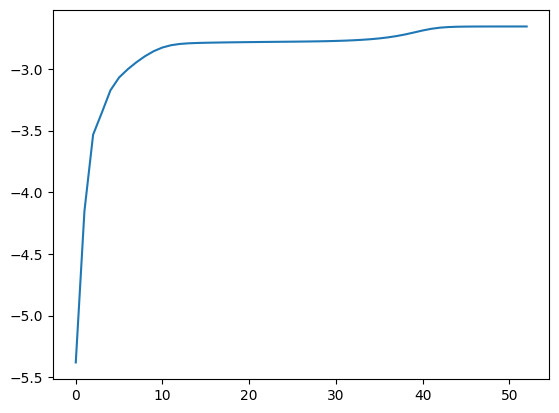

In [31]:
plt.plot(loglikes)
plt.show

In [32]:
metrics.adjusted_rand_score(y, zs)

0.8553942650426022

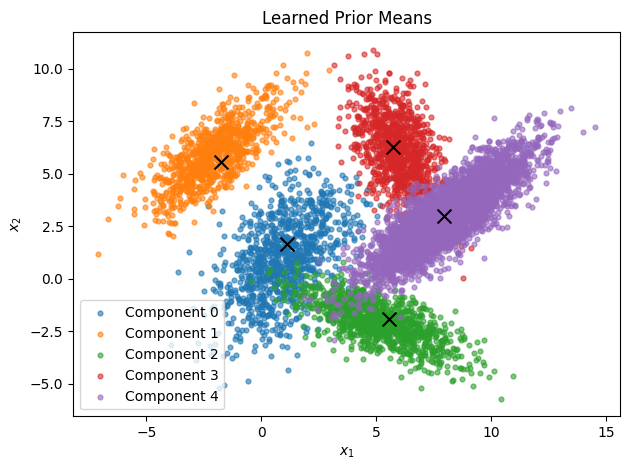

In [33]:
'''  
    Plot learned mean priors (m_k) against ground truth clusters
'''

plot_clusters(X,y,5,m,title="Learned Prior Means")

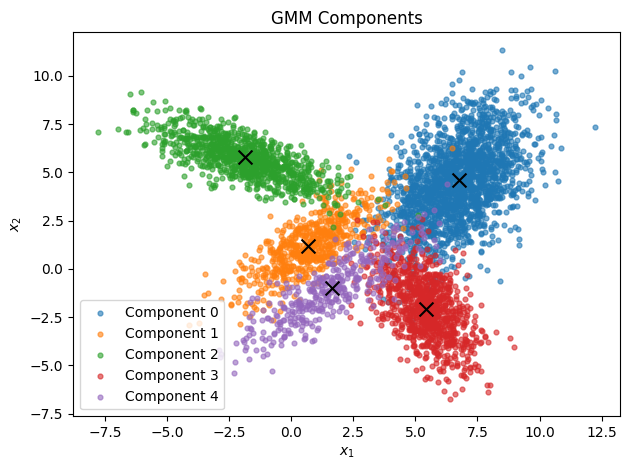

In [ ]:
'''  
    Plot cluster samples from posterior predictive distribution
'''
x,c = sample_posterior_predictive(4850, m,S,Σ,alphas)
plot_clusters(x,c,5,m)

There is a label switching issue where the $\Sigma$ no longer correspond to the correct $\mu$ above.